# Step 6 - Learn all the parameters

*Consider the general case in which the shop needs to optimize the prices and the assignment of promos to the customers in the case all the parameters need to be learnt.*

In [10]:
import mab.Environment
import mab.Shop
from mab.ucb_learner import *
from mab.utilities import *

## Shop and Environment initialization

In [11]:
shop_small_ts = Shop.Shop()
shop_ucb = Shop.Shop()

shop_ts = Shop.Shop()
shop_big_ts = Shop.Shop()
shop_ts3 = Shop.Shop()
shop_clairvoyant = Shop.Shop()

env = Environment.Environment(shop_small_ts.prices1, shop_small_ts.prices2, shop_small_ts.discounts)

shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)


price_arms = [(i, j) for i in range(len(shop_small_ts.prices1)) for j in range(len(shop_small_ts.prices2))]
n_price_arms = len(price_arms)

matching_arms = [(i, j, k, l) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2)) for k in range(shop_ts.n_classes) for l in range(len(shop_ts.discounts))]
n_matching_arms = len(matching_arms)

small_matching_arms = [(i, j) for i in range(shop_small_ts.n_classes) for j in range(len(shop_small_ts.discounts))]
small_n_matching_arms = len(small_matching_arms)

shop_small_ts.set_assignment_learner('TS', small_n_matching_arms)
shop_ucb.set_assignment_learner('UCB', small_n_matching_arms)

shop_small_ts.set_price_learner('TS', 5)
shop_ucb.set_price_learner('UCB', 5)

shop_small_ts.set_price2_learner('TS', 5)
shop_ucb.set_price2_learner('UCB', 5)

shop_ts.set_price_learner('TS', n_price_arms)
shop_ts.set_assignment_learner('TS', n_matching_arms)

shop_ts3.set_price_learner('TS', 5)
shop_ts3.set_price2_learner('TS', n_price_arms)
shop_ts3.set_assignment_learner('TS', n_matching_arms)


shop_big_ts.set_assignment_learner('TS', n_matching_arms)

In [12]:
generated_promo_ratios = np.array([0.4, 0.25, 0.2, 0.15])
max_ind_reward = max(env.prices1) + max(env.prices2)

## Shop and Environment initialization

In [13]:
#### get clairvoyant price
expected_rewards = np.zeros((5,5)) # price1*price2
shop_clairvoyant.set_expected_customers(np.array([25, 25, 25, 25]))
customers_mean = np.array([25, 25, 25, 25])

##### other way to calculate clairvoyant
cec = shop_clairvoyant.get_customer_list()
cep = shop_clairvoyant.get_promo_list(generated_promo_ratios)

cmt, cpa, cer, ers  = shop_clairvoyant.get_clairvoyant_prices_and_matching(cec, cep, 5, 5)

cp1idx = price_arms[cpa][0]
cp2idx = price_arms[cpa][1]
cp1 = env.prices1[cp1idx]
cp2 = env.prices2[cp2idx]

cpf = shop_clairvoyant.get_promo_fractions_from_tuples(cmt)

print(cpf)
print(cp1)
print(cp2)
print(cer)

[[0.6 0.  0.  0.4]
 [0.  1.  0.  0. ]
 [0.  0.  0.8 0.2]
 [1.  0.  0.  0. ]]
120.0
300.0
26020.582091544602


## Online Simulation
Here follows the online simulation over a time horizon of one year.

TBD

In [14]:
days = 365

u_rewards_per_class_per_day = []
small_ts_rewards_per_class_per_day = []

ts_rewards_per_class_per_day = []
ts3_rewards_per_class_per_day = []
big_ts_rewards_per_class_per_day = []
c_rewards_per_class_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

for day in range(days):
    if day == 0:
        shop_ts.set_expected_customers(customers_ie)
        shop_big_ts.set_expected_customers(customers_ie)
        shop_ts3.set_expected_customers(customers_ie)
        shop_ucb.set_expected_customers(customers_ie)
        shop_small_ts.set_expected_customers(customers_ie)
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        shop_ucb.set_expected_customers((customers_em + 0.99).astype(int))
        shop_small_ts.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts3.set_expected_customers((customers_em + 0.99).astype(int))
        shop_big_ts.set_expected_customers((customers_em + 0.99).astype(int))
    
    # select the price for 2 step learner
    chosen_price_tuple_idx_ts = shop_ts.price_learner.pull_arm()

    price1idx_ts = price_arms[chosen_price_tuple_idx_ts][0]
    price2idx_ts = price_arms[chosen_price_tuple_idx_ts][1]
    price1_ts = env.prices1[price_arms[chosen_price_tuple_idx_ts][0]]
    price2_ts = env.prices2[price_arms[chosen_price_tuple_idx_ts][1]]

    # perform matching and get promo fractions for 2 step learner
    expected_customers_ts = shop_ts.get_customer_list()
    expected_promos_ts = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts = shop_ts.assignment_learner.pull_arm_matching(expected_customers_ts, expected_promos_ts, matching_arms, price1idx_ts, price2idx_ts)
    promo_fractions_ts = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts)

    # get promo fractions and prices for big learner
    expected_customers_big_ts = shop_big_ts.get_customer_list()
    expected_promos_big_ts = shop_big_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_big_ts, price_arm_index_big_ts = shop_big_ts.assignment_learner.pull_arm_all(expected_customers_big_ts, expected_promos_big_ts, matching_arms, len(env.prices1), len(env.prices2))
    promo_fractions_big_ts = shop_big_ts.get_promo_fractions_from_tuples(matched_tuples_big_ts)

    price1idx_big_ts = price_arms[price_arm_index_big_ts][0]
    price2idx_big_ts = price_arms[price_arm_index_big_ts][1]
    price1_big_ts = env.prices1[price1idx_big_ts]
    price2_big_ts = env.prices2[price2idx_big_ts]

    # pricing and matching for 3-step dependent learner
    price1idx_ts3 = shop_ts3.price_learner.pull_arm()
    price2idx_ts3 = shop_ts3.price2_learner.pull_arm_price2(price1idx_ts3, price_arms)

    price1_ts3 = env.prices1[price1idx_ts3]
    price2_ts3 = env.prices2[price2idx_ts3]
    
    expected_customers_ts3 = shop_ts3.get_customer_list()
    expected_promos_ts3 = shop_ts3.get_promo_list(generated_promo_ratios)

    matched_tuples_ts3 = shop_ts3.assignment_learner.pull_arm_matching(expected_customers_ts3, expected_promos_ts3, matching_arms, price1idx_ts3, price2idx_ts3)
    promo_fractions_ts3 = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts3)

    # get expected list of customers
    expected_customers_u = shop_ucb.get_customer_list()
    expected_customers_small_ts = shop_small_ts.get_customer_list()

    # get expected list of promos
    expected_promos_u = shop_ucb.get_promo_list(generated_promo_ratios) 
    expected_promos_small_ts = shop_small_ts.get_promo_list(generated_promo_ratios) 

    #Pull arm price1 from learners 
    chosen_price1_small_ts = env.prices1[shop_small_ts.price_learner.pull_arm()]
    chosen_price1_ucb = env.prices1[shop_ucb.price_learner.pull_arm()] 

    #Pull arm price2 from learners 
    chosen_price2_small_ts = env.prices2[shop_small_ts.price2_learner.pull_arm()]
    chosen_price2_ucb = env.prices2[shop_ucb.price2_learner.pull_arm()] 
    

    # generate the connections and their expected weights
    matched_tuples_u = shop_ucb.assignment_learner.pull_arm_matching(expected_customers_u, expected_promos_u, small_matching_arms)
    matched_tuples_small_ts = shop_small_ts.assignment_learner.pull_arm_matching(expected_customers_small_ts, expected_promos_small_ts, small_matching_arms)
 
    promo_fractions_u = shop_ucb.get_promo_fractions_from_tuples(matched_tuples_u)
    promo_fractions_small_ts = shop_small_ts.get_promo_fractions_from_tuples(matched_tuples_small_ts)

    # simulate the day
    env.generate_next_day_customers()

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_small_ts = []
    revenue_ucb = []
    revenue_ts = []
    revenue_ts3 = []
    revenue_big_ts = []
    revenue_c = []

    small_ts_total_reward = 0
    ucb_total_reward = 0
    big_ts_total_reward = 0
    ts_total_reward = 0
    c_total_reward = 0

    c_count = 0

    for cust in customers:
        ts_ind_reward = 0

        selected_promo_small_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_small_ts[cust])
        selected_promo_u = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_u[cust])
        selected_promo_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts[cust])
        selected_promo_big_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_big_ts[cust])
        selected_promo_c = np.random.choice([0, 1, 2, 3], 1, p=cpf[cust])
        selected_promo_ts3 = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts3[cust])

        small_ts_buy1 = env.round1(cust, chosen_price1_small_ts)
        small_ts_buy2 = 0
        if small_ts_buy1:
            small_ts_buy2 = env.round2(cust, selected_promo_small_ts, chosen_price2_small_ts)
        
        u_buy1 = env.round1(cust, chosen_price1_ucb)
        u_buy2 = 0
        if u_buy1:
            u_buy2 = env.round2(cust, selected_promo_u, chosen_price2_ucb)

        ts_buy1 = env.round1(cust, price1_ts)
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo_ts, price2_ts)

        ts3_buy1 = env.round1(cust, price1_ts3)
        ts3_buy2 = 0
        if ts3_buy1:
            ts3_buy2 = env.round2(cust, selected_promo_ts3, price2_ts3)

        big_ts_buy1 = env.round1(cust, price1_big_ts)
        big_ts_buy2 = 0
        if big_ts_buy1:
            big_ts_buy2 = env.round2(cust, selected_promo_big_ts, price2_big_ts)
        
        small_ts_ind_reward= small_ts_buy1*chosen_price1_small_ts + small_ts_buy2*chosen_price2_small_ts*(1-shop_small_ts.discounts[selected_promo_small_ts])
        u_ind_reward = u_buy1*chosen_price1_ucb + u_buy2*chosen_price2_ucb*(1-shop_ucb.discounts[selected_promo_u])
        ts_ind_reward = ts_buy1*price1_ts + ts_buy2*price2_ts*(1-shop_ts.discounts[selected_promo_ts])
        big_ts_ind_reward = big_ts_buy1*price1_big_ts + big_ts_buy2*price2_big_ts*(1-shop_big_ts.discounts[selected_promo_big_ts])
        ts3_ind_reward = ts3_buy1*price1_ts3 + ts3_buy2*price2_ts3*(1-shop_ts3.discounts[selected_promo_ts3])

        c_ind_reward = env.true_conv1[cust, cp1idx]*cp1 + env.true_conv1[cust, cp1idx]*env.true_conv2[selected_promo_c, cust, cp2idx]*cp2*(1-shop_small_ts.discounts[selected_promo_c])

        
        norm_small_ts_ind_reward = small_ts_ind_reward / max_ind_reward
        norm_u_ind_reward = u_ind_reward / max_ind_reward
        norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        norm_ts3_ind_reward = ts3_ind_reward / max_ind_reward
        norm_big_ts_ind_reward = big_ts_ind_reward / max_ind_reward

        # update 3-step ts
        shop_ts3.price_learner.update(price1idx_ts3, norm_ts3_ind_reward)

        price_tuples_idx_ts3 = price_arms.index((price1idx_ts3, price2idx_ts3))
        shop_ts3.price2_learner.update(price_tuples_idx_ts3, norm_ts3_ind_reward)

        matching_arm_index_ts3 = matching_arms.index((price1idx_ts3, price2idx_ts3, cust, selected_promo_ts3))
        shop_ts3.assignment_learner.update(matching_arm_index_ts3, norm_ts3_ind_reward)

        # update price learner and assignment learner
        shop_ucb.assignment_learner.update(small_matching_arms.index((cust, selected_promo_u)), norm_u_ind_reward)
        shop_small_ts.assignment_learner.update(small_matching_arms.index((cust, selected_promo_small_ts)), norm_small_ts_ind_reward)
        
        shop_ts.price_learner.update(chosen_price_tuple_idx_ts, norm_ts_ind_reward)
        matching_arm_index_ts = matching_arms.index((price1idx_ts, price2idx_ts, cust, selected_promo_ts))
        shop_ts.assignment_learner.update(matching_arm_index_ts, norm_ts_ind_reward)

        # buradaki matching arm index sadece price ikilisini veriyor
        matching_arm_index_big_ts = matching_arms.index((price1idx_big_ts, price2idx_big_ts, cust, selected_promo_big_ts))
        shop_big_ts.assignment_learner.update(matching_arm_index_big_ts, norm_big_ts_ind_reward)

        revenue_ucb.append(u_ind_reward)
        revenue_small_ts.append(small_ts_ind_reward)
        revenue_ts.append(ts_ind_reward)
        revenue_ts3.append(ts3_ind_reward)
        revenue_big_ts.append(big_ts_ind_reward)
        revenue_c.append(c_ind_reward)

    small_ts_rewards_per_class_per_day.append(np.mean(revenue_small_ts))
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    ts3_rewards_per_class_per_day.append(np.mean(revenue_ts3))
    big_ts_rewards_per_class_per_day.append(np.mean(revenue_big_ts))
    c_rewards_per_class_per_day.append(np.mean(revenue_c))

In [17]:
print(np.cumsum(c_rewards_per_class_per_day)[-1] - np.cumsum(small_ts_rewards_per_class_per_day)[-1])
print(np.cumsum(c_rewards_per_class_per_day)[-1] - np.cumsum(u_rewards_per_class_per_day)[-1])

46906.95676732908
49460.0889948329


## Results Analysis

Text(0, 0.5, 'Revenue')

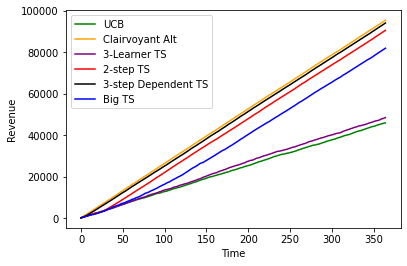

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(np.cumsum(u_rewards_per_class_per_day), color='green', label='UCB')
plt.plot(np.cumsum(c_rewards_per_class_per_day), color='orange', label='Clairvoyant')
plt.plot(np.cumsum(small_ts_rewards_per_class_per_day), color='purple', label='3-Learner TS')
plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='2-step TS')
plt.plot(np.cumsum(ts3_rewards_per_class_per_day), color='black', label='3-step Dependent TS')
plt.plot(np.cumsum(big_ts_rewards_per_class_per_day), color='blue', label='Big TS')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

Text(0, 0.5, 'Regret')

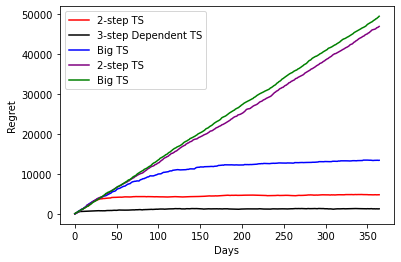

In [19]:
plt.figure(figsize=(10,3))
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='2-step TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(ts3_rewards_per_class_per_day)), color='black', label='3-step Dependent TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(big_ts_rewards_per_class_per_day)), color='blue', label='Big TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(small_ts_rewards_per_class_per_day)), color='purple', label='2-step TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='green', label='Big TS')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')